## Chargement du dataset complet

In [1]:
import pandas as pd

from src.data_eng.prepare_db import *

full_dataset = load_dataset("bank-additional-full.csv")
print("Le dataset contient", len(full_dataset), "lignes")
full_dataset.head()

Le dataset contient 41188 lignes


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


## Statistiques de la variable cible
Commençons par remplacer la variable cible par des entiers 1/0

In [2]:
target_column = "y"
full_dataset[target_column] = full_dataset[target_column].map({"yes": 1, "no": 0})
print("Taux de cible:\n", full_dataset[target_column].value_counts(normalize=True))
print("Fréquences de la cilbe:\n", full_dataset[target_column].value_counts())


Taux de cible:
 0    0.887346
1    0.112654
Name: y, dtype: float64
Fréquences de la cilbe:
 0    36548
1     4640
Name: y, dtype: int64


## Typage des variables explicatives

In [3]:
features = full_dataset.columns[:-1]
print("La variables disponibles en entrées sont", features)
print("Typage des variables:\n", full_dataset.dtypes)

La variables disponibles en entrées sont Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed'],
      dtype='object')
Typage des variables:
 age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                   int64
dtype: object


In [4]:
continuous_features = [col for col in features if full_dataset[col].dtype != 'object']
print("Variables continues:", continuous_features)
categorical_features = [col for col in features if full_dataset[col].dtype == 'object']
print("Variables categoriques:", categorical_features)
print("Toutes les variables sont prises en compte:",
      (set(categorical_features).union(continuous_features)).difference(set(features)))

Variables continues: ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
Variables categoriques: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
Toutes les variables sont prises en compte: set()


## Corrélation variable cible / Variable

### Variables continues

In [5]:
from src.analysis.exploratory_functions import *

correlations = compute_pb_correlation(full_dataset, continuous_features, target_column)
print(correlations.sort_values(by="abs_corr", ascending=False))


          feature      corr  abs_corr
1        duration  0.405274  0.405274
9     nr.employed -0.354678  0.354678
3           pdays -0.324914  0.324914
8       euribor3m -0.307771  0.307771
5    emp.var.rate -0.298334  0.298334
4        previous  0.230181  0.230181
6  cons.price.idx -0.136211  0.136211
2        campaign -0.066357  0.066357
7   cons.conf.idx  0.054878  0.054878
0             age  0.030399  0.030399


### Variables catégoriques

In [6]:
cramers_v_corr = compute_cramers_v(full_dataset, categorical_features, target_column)
print(cramers_v_corr.sort_values(by="cra_v", ascending=False))

       feature     cra_v
9     poutcome  0.320488
7        month  0.274395
0          job  0.152768
6      contact  0.144773
3      default  0.099354
2    education  0.068472
1      marital  0.054570
8  day_of_week  0.025195
4      housing  0.011748
5         loan  0.005154


In [7]:
from src.modelling.cross_validation import *

train, test = split_dataset(full_dataset, 0.6)
train_targets = train[target_column]
test_targets = test[target_column]
train = train[continuous_features+categorical_features]
train = pd.get_dummies(train, columns = categorical_features, drop_first=True)
test = test[continuous_features+categorical_features]
test = pd.get_dummies(test, columns = categorical_features, drop_first=True)
print(train.columns)
print(test.columns)

Index(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_married', 'marital_single', 'marital_unknown',
       'education_basic.6y', 'education_basic.9y', 'education_high.school',
       'education_illiterate', 'education_professional.course',
       'education_university.degree', 'education_unknown', 'default_unknown',
       'default_yes', 'housing_unknown', 'housing_yes', 'loan_unknown',
       'loan_yes', 'contact_telephone', 'month_aug', 'month_dec', 'month_jul',
       'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct',
       'month_sep', 'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue',
       'day_of_week_wed', 'poutcome_nonexistent', 'poutcome_s

### Corrélation entre features

In [8]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_data = pd.DataFrame()
vif_data["feature"] = train.columns
vif_data["VIF"] = [variance_inflation_factor(train.values, i)
                          for i in range(len(train.columns))]


/Users/philippe.stepniewski/projets/Dojo_Banking/venv/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [9]:
vif_data["VIF"] = vif_data["VIF"].apply(lambda x: '%.5f' % x)
print(vif_data.sort_values(by ="VIF",ascending=False))

                          feature          VIF
33                housing_unknown          inf
35                   loan_unknown          inf
5                    emp.var.rate     94.33486
9                     nr.employed  80722.28109
38                      month_aug      8.21263
8                       euribor3m    797.06684
43                      month_may      7.69067
6                  cons.price.idx  63513.94536
4                        previous      6.79212
21                marital_married      6.63919
29    education_university.degree      5.99867
40                      month_jul      5.51153
37              contact_telephone      5.13144
26          education_high.school      4.48514
22                 marital_single      4.10797
7                   cons.conf.idx    395.75428
51           poutcome_nonexistent     37.97098
3                           pdays    321.17626
44                      month_nov      3.95775
41                      month_jun      3.79932
28  education

In [ ]:
from xgboost import XGBClassifier
from src.modelling.cross_validation import feature_selection
results_selection = feature_selection(XGBClassifier, train, train_targets, test,test_targets, metric=f1_score)

40    duration,pdays,emp.var.rate,cons.price.idx,con...
Name: selected_features, dtype: object


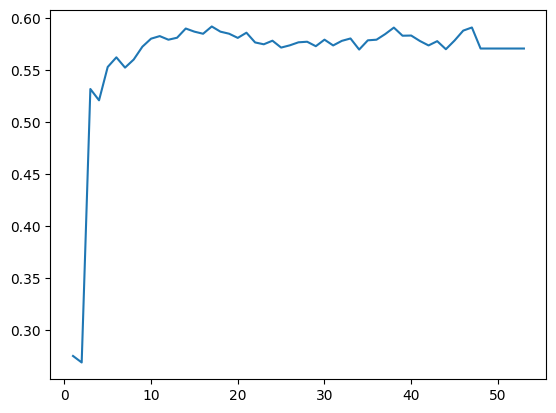

In [18]:
results_selection = pd.DataFrame(results_selection)
plt.plot(results_selection["number of features"],results_selection["metric"])
print(results_selection[results_selection["number of features"] == 13].selected_features)

In [15]:

xgb = XGBClassifier(n_estimators=500, objective='binary:logistic',
                    silent=True, nthread=1)
params = {'learning_rate': [0.01, 0.05, 0.1],
          'max_depth': [3, 4, 5],
          'min_child_weight': [1, 5, 10],
          'gamma': [0.5, 1, 1.5, 2, 5],
          'subsample': [0.6, 0.8, 1.0],
          'colsample_bytree': [0.6, 0.8, 1.0]}
res_grid = gridsearch_with_cv(train,
                              target_y=train_targets, parameters_grids=params, num_params_iter_max=1,
                              cv_folds=5, estimator=xgb, metric='roc_auc')


Fitting 5 folds for each of 1 candidates, totalling 5 fits


KeyboardInterrupt: 

In [ ]:
from src.modelling.model_analysis import plot_feature_importance

print('\n All results:')
results = pd.DataFrame(res_grid.cv_results_)
print(results)
print('\n Best estimator:')
print(res_grid.best_estimator_)
print('\n Best hyperparameters:')
print(res_grid.best_params_)
print(set(train.columns).difference(set(test.columns)))



In [ ]:
from src.modelling.model_analysis import save_and_plot_partial_dependence_plots
save_and_plot_partial_dependence_plots(model, train,["duration"])

In [ ]:
from sklearn.metrics import classification_report
print(set(train.columns).difference(set(test.columns)))
print(test_targets.value_counts())
prediction = res_grid.best_estimator_.predict(test)

disp = classification_report(test_targets, prediction)
print(disp)

In [ ]:
from src.modelling.model_analysis import plot_shapley_values
plot_shapley_values(model, test, 0.05)